In [1]:
%load_ext autoreload
%autoreload 2

# Examples of used augmentations

In [2]:
from pathlib import Path

from hw_asr.datasets import CustomDirAudioDataset
from hw_asr.utils.parse_config import ConfigParser


ROOT_PATH = Path('.')


audio_dir = str(ROOT_PATH / "test_data" / "audio")
transc_dir = str(ROOT_PATH / "test_data" / "transcriptions")
config_parser = ConfigParser.get_test_configs()
dataset = CustomDirAudioDataset(
    audio_dir,
    transc_dir,
    text_encoder=config_parser.get_text_encoder(),
    config_parser=config_parser,
    limit=10,
    max_audio_length=10,
    max_text_length=200)

/Users/trickman/hse3/deep_learning/dl_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/trickman/hse3/deep_learning/dl_env/lib/python3.10/site-packages/torchvision/image.so, 6): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: /Users/trickman/hse3/deep_learning/dl_env/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /Users/trickman/hse3/deep_learning/dl_env/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/trickman/hse3/deep_learning/dl_env/lib/python3.10/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extension: {e}")


0 (0.0%) records are longer then 10 seconds. Excluding them.
0 (0.0%) records are longer then 200 characters. Excluding them.


In [3]:
sr = config_parser.config['preprocessing']['sr']
sr

16000

In [4]:
from IPython import display
from matplotlib import pyplot as plt

import torch


def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

In [5]:
audio = dataset[0]['audio']

/Users/trickman/hse3/deep_learning/dl_env/lib/python3.10/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


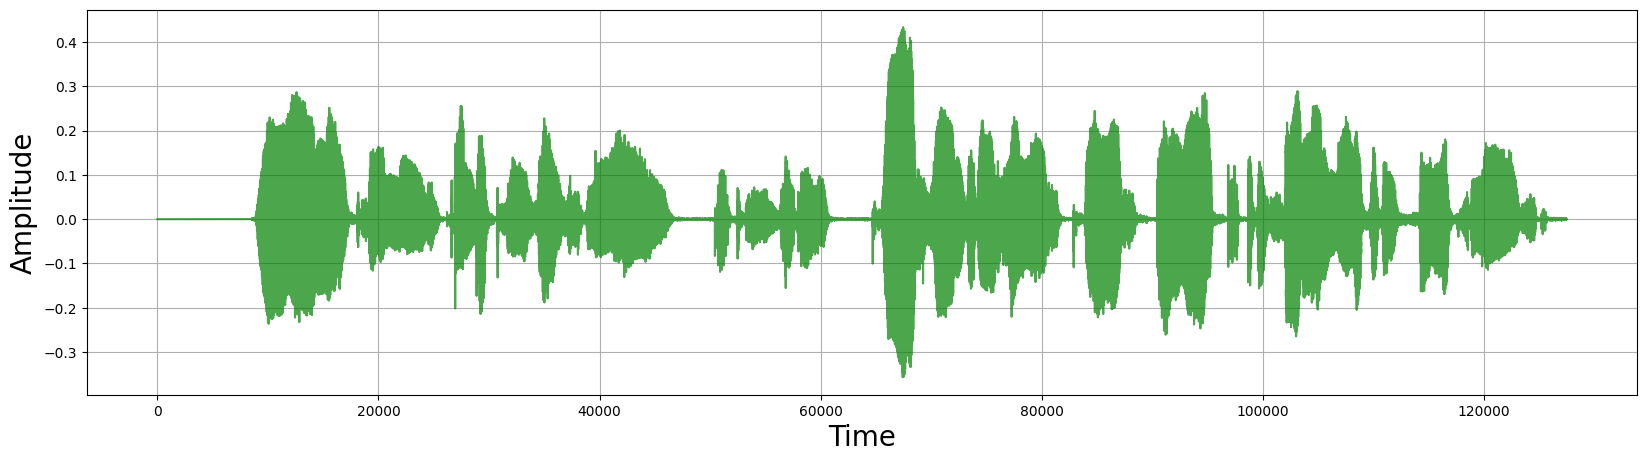

In [6]:
visualize_audio(audio, sr=sr)

## Gain (already implemented)

> Multiply the audio by a random amplitude factor to reduce or increase the volume

In [7]:
from hw_asr.augmentations.wave_augmentations.Gain import Gain

In [8]:
gain = Gain(output_type='tensor')
augmented_audio = gain(audio)

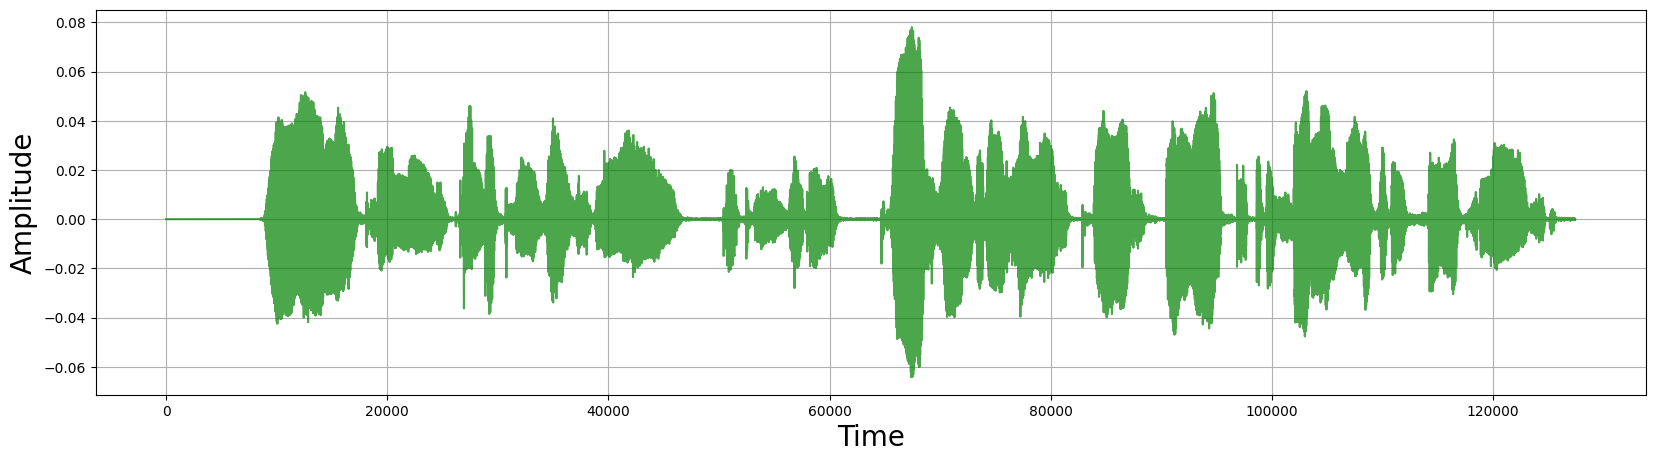

In [9]:
visualize_audio(augmented_audio, sr=sr)

## AddBackgroundNoise

In [10]:
import random


def create_noise(dataset, length: int) -> torch.Tensor:
    random_tensors = []
    for _ in range(3_000):
        i = random.randint(0, len(dataset) - 1)
        audio = dataset[i]['audio']
        l = random.randint(0, audio.shape[1])
        r = min(audio.shape[1], l + 50)
        random_tensors.append(audio[:, l:r])
    return torch.concat(random_tensors, dim=1)

In [11]:
from hw_asr.datasets import LibrispeechDataset


librispeech_dataset = LibrispeechDataset(
    'dev-clean',
    text_encoder=config_parser.get_text_encoder(),
    config_parser=config_parser,
    max_text_length=140,
    max_audio_length=13,
    limit=200,   
)

288 (10.7%) records are longer then 13 seconds. Excluding them.
671 (24.8%) records are longer then 140 characters. Excluding them.
Filtered 671(24.8%) records  from dataset


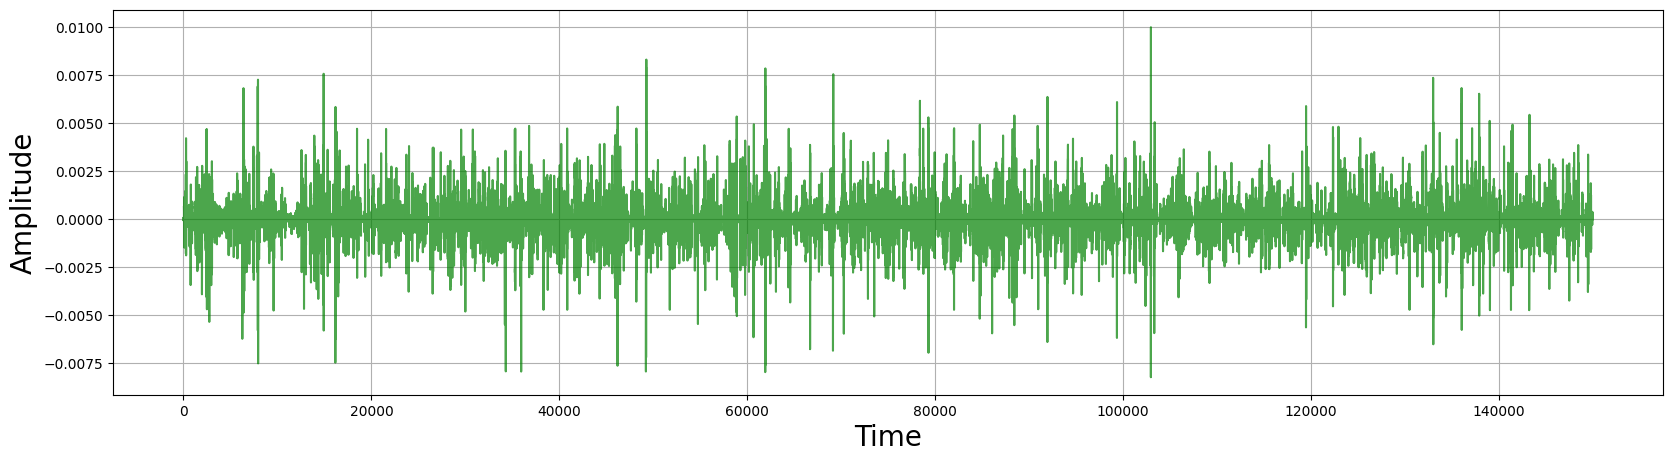

In [12]:
noise = create_noise(librispeech_dataset, 0)
noise = noise / noise.abs().max() * 0.01
visualize_audio(noise, sr)

In [13]:
import torchaudio


torchaudio.save('noise.wav', noise, sample_rate=sr, format='wav')

In [14]:
from torch_audiomentations import AddBackgroundNoise

In [15]:
noiser = AddBackgroundNoise('noise.wav', sample_rate=sr, p=1., output_type='tensor')

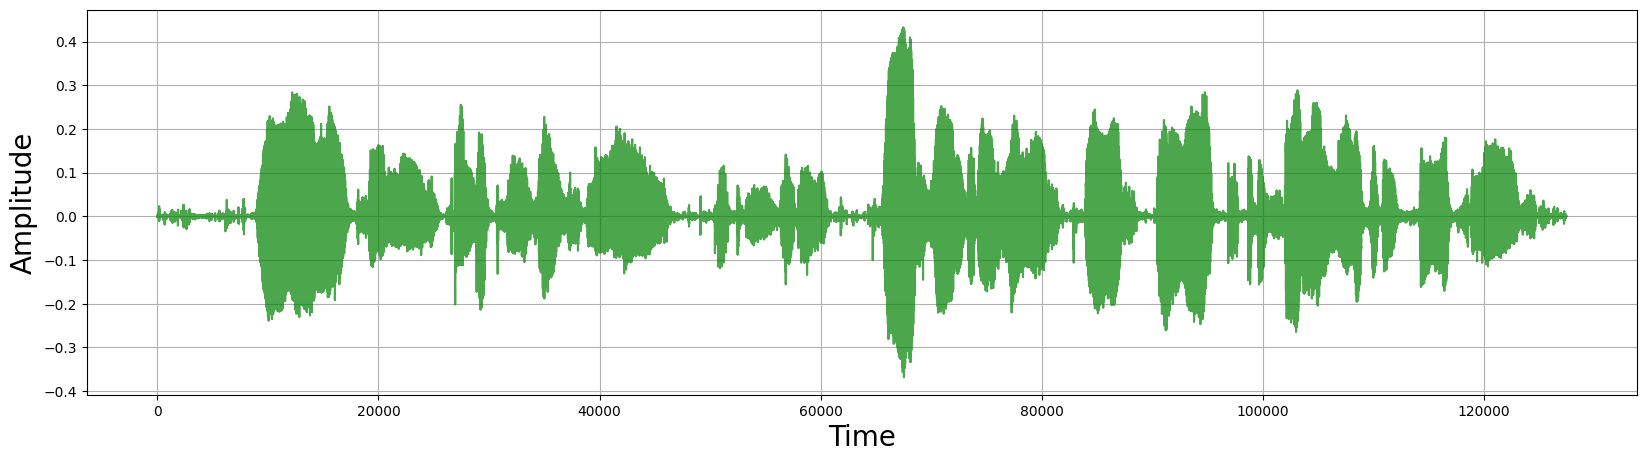

In [16]:
noised_audio = noiser(audio.unsqueeze(0))[0]
visualize_audio(noised_audio, sr)

# PitchShift

In [17]:
from torch_audiomentations import PitchShift

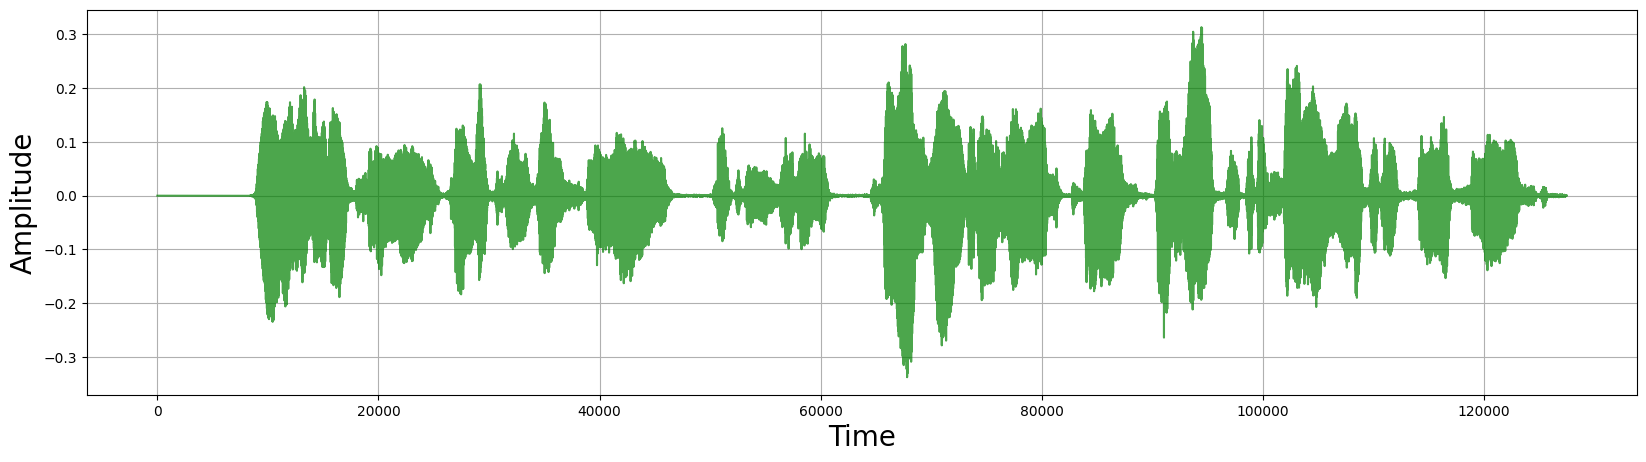

In [18]:
shifter = PitchShift(p=1., sample_rate=sr, output_type='tensor')
shifted_audio = shifter(audio.unsqueeze(0))[0]
visualize_audio(shifted_audio, sr)

# Time/Freq masking

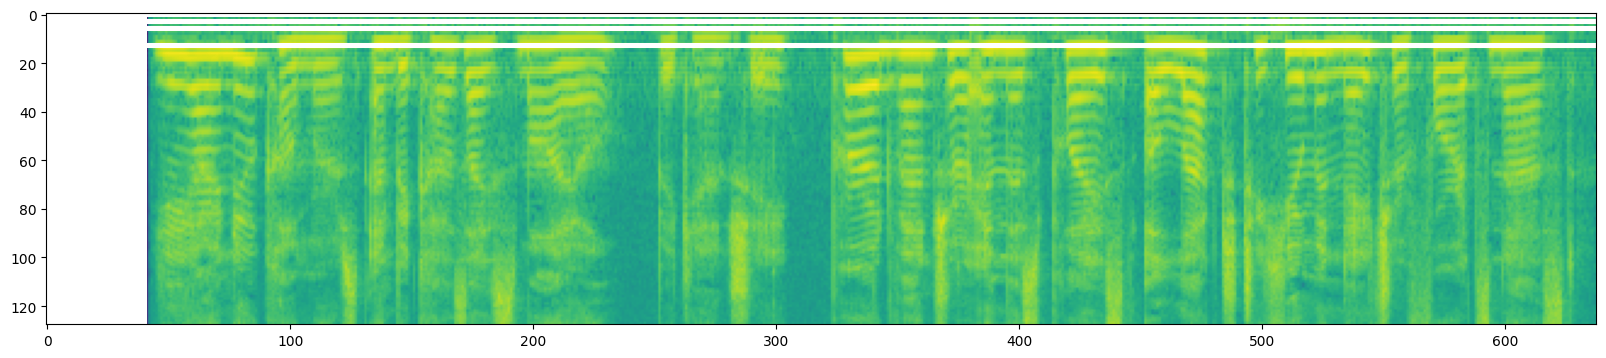

In [40]:
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr)
spec = torch.log(mel_transform(audio)).squeeze()

plt.figure(figsize=(20, 5))
plt.imshow(spec)

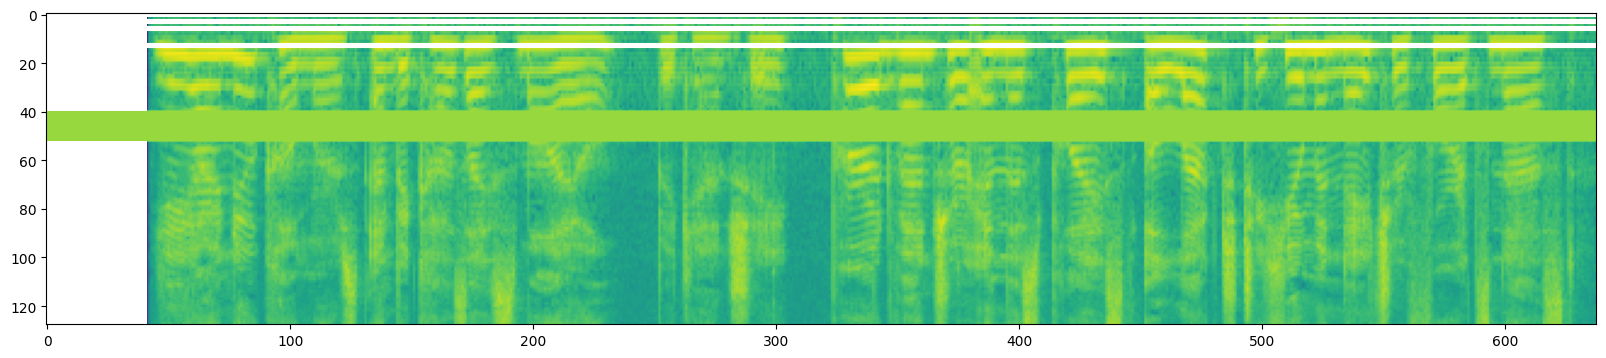

In [46]:
from hw_asr.augmentations.spectrogram_augmentations.FrequencyMasking import FrequencyMasking


transform = FrequencyMasking(freq_mask_param=24)
spec_aug = transform(spec)

plt.figure(figsize=(20, 5))
plt.imshow(spec_aug)

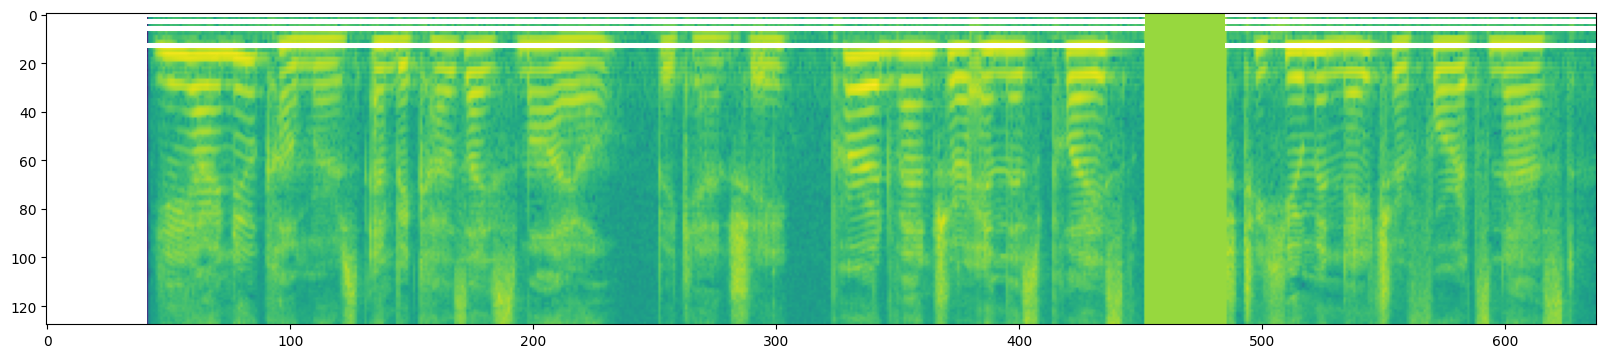

In [48]:
from hw_asr.augmentations.spectrogram_augmentations.TimeMasking import TimeMasking


transform = TimeMasking(time_mask_param=50)
spec_aug = transform(spec)

plt.figure(figsize=(20, 5))
plt.imshow(spec_aug)